Code for **"Prior effect"** figure from supmat.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1 
factor = 4
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two

PLOT = True

# Load image

HR and LR resolutions: (256, 160), (64, 40)


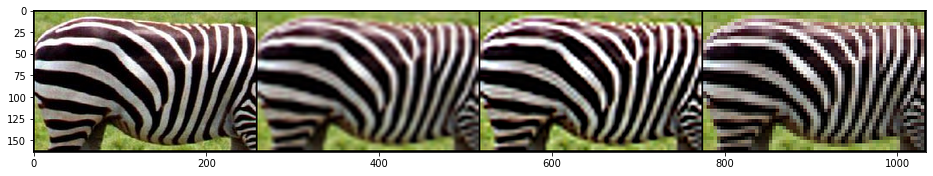

PSNR bicubic: 20.6285   PSNR nearest: 17.4030


In [3]:
fname  = 'data/sr/zebra_crop.png'

imgs = load_LR_HR_imgs_sr(fname, imsize, factor, enforse_div32)

if PLOT:
    imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        compare_psnr(imgs['HR_np'], imgs['bicubic_np']), 
                                        compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

In [4]:
def closure():
    
    global i, net_input
    
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) + tv_weight * tv_loss(out_HR)
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 500 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], np.clip(out_HR_np, 0, 1)], factor=8, nrow=2, interpolation='lanczos')

    i += 1
    
    return total_loss

# Experiment 1: no prior, optimize over pixels

In [5]:
input_depth = 3
 
INPUT = 'noise'
pad = 'reflection'
OPT_OVER = 'input'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

num_iter = 2000
reg_noise_std = 0.0

In [6]:
# Identity mapping network, optimize over `net_input`
net = nn.Sequential()
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type='lanczos2', phase=0.5, preserve_size=True).type(dtype)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

Starting optimization with ADAM


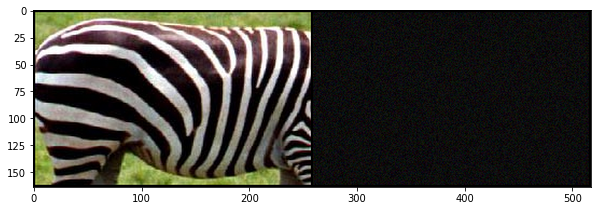

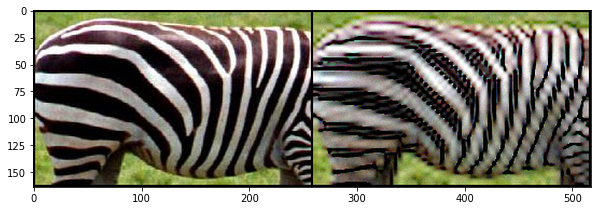

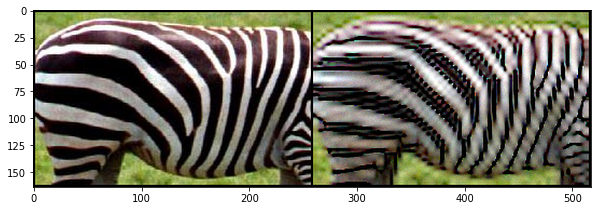

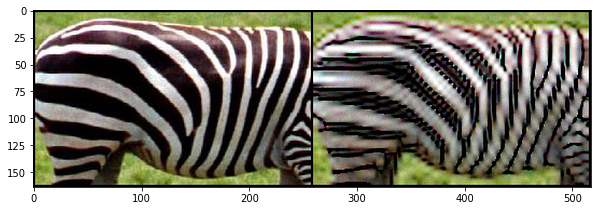

In [7]:
psnr_history = [] 
i = 0
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
 
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)

result_no_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])
psnr_history_direct = psnr_history

# Experiment 2: using TV loss

In [ ]:
tv_weight = 1e-7
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

psnr_history = [] 
i = 0
 
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)

result_tv_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])
psnr_history_tv = psnr_history

# Experiment 3: using deep prior

Same setting, but use parametrization.

In [ ]:
OPT_OVER = 'net'
reg_noise_std = 1./30. # This parameter probably should be set to a lower value for this example
tv_weight = 0.0

net = skip(input_depth, 3, num_channels_down = [128, 128, 128, 128, 128], 
                           num_channels_up   = [128, 128, 128, 128, 128],
                           num_channels_skip = [4, 4, 4, 4, 4], 
                           upsample_mode='bilinear',
                           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

In [ ]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)

result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])
psnr_history_deep_prior = psnr_history

# Comparison

In [ ]:
plot_image_grid([imgs['HR_np'], 
                 result_no_prior, 
                 result_tv_prior, 
                 result_deep_prior], factor=8, nrow=2);